In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

### Load Annotated Data

In [2]:
data_filename  = '../../data/v4_annotated/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d_b = load_cf_labels(data_filename)
d_b = tidy_labels(d_b)

data_filename  = '../../data/v4_annotated/annotated_random_data_rows_0_to_5000_raters_20.csv'
d_r = load_cf_labels(data_filename)
d_r = tidy_labels(d_r)

In [3]:
l_b = plurality(d_b['attack'].dropna())
l_r = plurality(d_r['attack'].dropna())

In [4]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

### NGram Classification Pipeline

In [5]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LinearSVC()),
])

In [6]:
param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (0.001, 0.1, 1.0)
}

In [7]:
train, test = split(data_b)
model = tune (train['x'], train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)
evaluate(model, test, roc_auc, plot = False)


Best parameters set found:
{'clf__C': 1.0, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'} 0.869963338168


Grid scores:
0.71767 (+/-0.00000) for {'clf__C': 0.001, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.70889 (+/-0.00000) for {'clf__C': 0.001, 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.86764 (+/-0.00000) for {'clf__C': 0.1, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.86862 (+/-0.00000) for {'clf__C': 0.1, 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.86996 (+/-0.00000) for {'clf__C': 1.0, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.86851 (+/-0.00000) for {'clf__C': 1.0, 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'vect__analyzer': 'char'}


0.86781609195402298

In [8]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6))),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LinearSVC(C = 1.0)),
])

### Error Analysis

In [9]:
fn, fp = get_clf_errors(model, test)

In [10]:
# extreme False negatives
print_clf_errors(fn)

COMMENT:
 I used profanity in my edit summaries, but I didn't know anything was wrong with that. A warning would have worked.  It's the same thing that administrators do. Being blocked for 48 hours is just gay.   
SCORES: Actual: 1, Predicted: 0, Score: -1.03


COMMENT:
maroo doingaroo itaroo becausearoo Iaroo sawaroo somearoo evolutionsaroo inaroo thataroo programaroo andaroo heardaroo thearoo onesaroo thataroo werearoo mentionedaroo, somebodyaroo addedaroo somearoo accordingaroo thingaroo onaroo itaroo whicharoo didaroo notaroo happenaroo inaroo thearoo showaroo
SCORES: Actual: 1, Predicted: 0, Score: -0.92


COMMENT:
You're mad?. Let me complete this article to this sunday, stop this madness with references, images, etc. Let me complete the article please. 190.242.99.226  20:25, 21 May 2013 (UTC)
SCORES: Actual: 1, Predicted: 0, Score: -0.88


COMMENT:
"Instead of being a lazy prick, and hitting the ""revert"" button repeatedly, this time maybe you will actually take the time to che

In [11]:
# extreme False positives
print_clf_errors(fp)

COMMENT:
 Big deal. Go ahead and block. I will see to it that you are blocked.
SCORES: Actual: 0, Predicted: 1, Score: 0.61


COMMENT:
Again, KUDOS for advancing the Democratic cause on Wikipedia!  But if that's something you're ashamed of, you should go ahead and ban me.
SCORES: Actual: 0, Predicted: 1, Score: 0.58


COMMENT:
"I'm just responding likewise.  You insist on double-talk and a lack of integrity and I'll treat you as you deserve.  You accuse me of not fully responding to you prior challenges.  After 2 weeks I'm still want you to explain the Jupiter/Pluto midpoint in your natal chart.  OR GET LOST!!!  Obviously, your ""problems"" which magnetizes you to a topic which you're not qualified to discuss plus your confession that you haven't studied Astrology PROVES you have ""issues"" you're not dealing with.   
SCORES: Actual: 0, Predicted: 1, Score: 0.40


COMMENT:
THE CIVIL DISCUSSION WAS IN MY EDIT AND YOU DELETED IT GO AHEAD TAKE AWAY MY EDITING RIGHTS i SPENT 3 HOURS MAKING

### Does adding random data improve prediction on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

In [13]:
ms, metrics = eval_adding_other_data(optimal_pipeline, data_b, data_r, roc_auc)

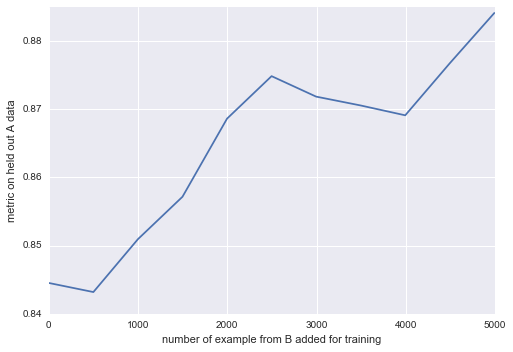

In [14]:
plot_adding_other_data(ms, metrics)

# Final Model

In [15]:
data = pd.concat([data_r,data_b])
model = optimal_pipeline.fit(data['x'], data['y'])
joblib.dump(model, '../../models/attack_ngram.pkl')

['../../models/attack_ngram.pkl',
 '../../models/attack_ngram.pkl_01.npy',
 '../../models/attack_ngram.pkl_02.npy',
 '../../models/attack_ngram.pkl_03.npy',
 '../../models/attack_ngram.pkl_04.npy',
 '../../models/attack_ngram.pkl_05.npy']